# In this notebook, we use some simple models to see how the use of both EEG and EOG affect the results of the sleep classification

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader, random_split
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer
from compute_fft import compute_spectrogram, plot_spectrogram, mask_and_replace
from models.CNN_BiLSTM_Attention import ParallelModel

# 1) Preparation of the pickle file, we need to compute it for every different set of data we want to study

For the moment let's only focus on the Sleep Cassette :
The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

In [3]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file

x is separed into 4 different experiments : EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental

In [245]:
data_test['header_raw']

array({'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 24-APR-1989 X X X', 'date_time': '2089-04-24 16:13:00', 'EDF+': False, 'contiguous': True, 'n_records': 2650, 'record_length': 30.0, 'n_channels': 7, 'label': ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker'], 'transducer_type': ['Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Ag-AgCl electrodes', 'Oral-nasal thermistors', 'Ag-AgCl electrodes', 'Rectal thermistor', 'Marker button'], 'units': ['uV', 'uV', 'uV', '', 'uV', 'DegC', ''], 'physical_min': array([ -192.,  -197., -1009., -2048.,    -5.,    34., -2047.]), 'physical_max': array([ 192.,  196., 1009., 2047.,    5.,   40., 2048.]), 'digital_min': array([-2048., -2048., -2048., -2048., -2500., -2849., -2047.]), 'digital_max': array([2047., 2047., 2047., 2047., 2500., 2731., 2048.]), 'prefiltering': ['HP:0.5Hz LP:100Hz [enhanced cassette BW]', 'HP:0.5Hz LP:100Hz [enhanced cassette BW]', 'HP:0.5Hz 

In [246]:
data_test['header_annotation']

array({'local_subject_id': 'X F X Female_33yr', 'local_recording_id': 'Startdate 24-APR-1989 X X X', 'date_time': '2089-04-24 16:13:00', 'EDF+': True, 'contiguous': True, 'n_records': 1, 'record_length': 0.0, 'n_channels': 1, 'label': ['EDF Annotations'], 'transducer_type': [''], 'units': [''], 'physical_min': array([0.]), 'physical_max': array([1.]), 'digital_min': array([-32768.]), 'digital_max': array([32767.]), 'prefiltering': [''], 'n_samples_per_record': [2054]},
      dtype=object)

We can then prepare the data for training and validation

In [247]:
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))

In [248]:
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measure_type=2     ## EOG or EEG etc...
measurement=data_test['ch_label'][2]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,measure_type] # Take only the EOG - change it to have both EOG and EEG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1]))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1]))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

100%|██████████| 153/153 [01:04<00:00,  2.36it/s]


In [249]:
print(xtrain.shape,ytrain.shape,xvalid.shape,yvalid.shape)

(175996, 600) (175996,) (19485, 600) (19485,)


In [250]:
# clean the first dummy example
xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
print(xtrain.shape, xvalid.shape)
print(ytrain.shape, yvalid.shape)

(175995, 600) (19484, 600)
(175995,) (19484,)


In [251]:
# In Torch version
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

Store data as a pickle file : to do only ONCE

In [341]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)

# 2) Open the pickle file : reuse this in a code to train a model

In [342]:
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)

In [343]:
print(ytrain.shape)

torch.Size([175995])


In [344]:
xtrain.shape  #175995 EEG of temporal size 600  

torch.Size([175995, 600])

Plot the data and visualize to what stage of sleep it corresponds

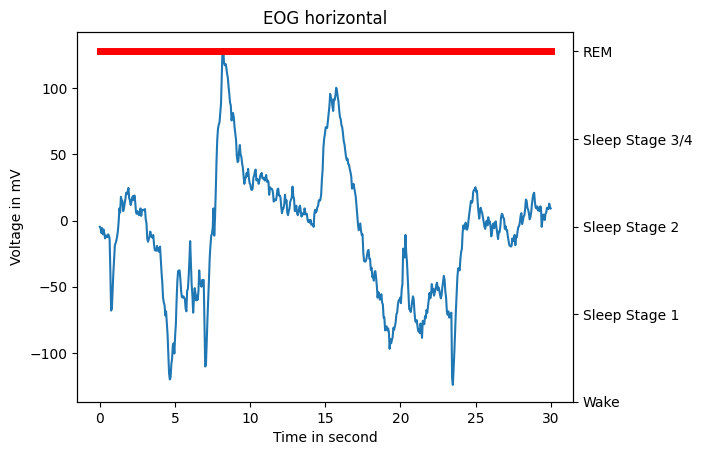

In [345]:
numero_analyse=555
time=np.linspace(0,30,xtrain.shape[1])

fig, ax1 = plt.subplots()

ax1.plot(time,xtrain[numero_analyse])
ax1.set_xlabel('Time in second')
ax1.set_ylabel('Voltage in mV')
ax2 = ax1.twinx()
ax2.plot(time,ytrain[numero_analyse]*np.ones(time.shape),color='red',linewidth=5)
ax2.set_yticks([0,1,2,3,4], ['Wake','Sleep Stage 1','Sleep Stage 2','Sleep Stage 3/4','REM'],fontsize=10)
plt.title(measurement)
plt.show()

Now we have understand everything about the data we can compute some models to train !

# 3) Training a basic model

In [346]:
from models import CNN_basic

In [347]:
model=CNN_basic.SimplifiedCNN(0.25)

In [348]:
xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:1000]),th.tensor(ytrain[:1000])
xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:1000]),th.tensor(yvalid[:1000])

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(dataset_t, batch_size= 100, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= 100, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_4922/2719476002.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:1000]),th.tensor(ytrain[:1000])
/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_4922/2719476002.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:1000]),th.tensor(yvalid[:1000])


In [349]:
#dataset_t = TensorDataset(xtrain, ytrain)
#dataset_size = len(dataset_t)
#half_dataset_size = dataset_size // 2
#dataset_t1, dataset_t2 = random_split(dataset_t,  [half_dataset_size, dataset_size - half_dataset_size])
#train_loader = DataLoader(dataset_t, batch_size= 10, shuffle=True)
#dataset_v = TensorDataset(xvalid, yvalid)
#dataset_size = len(dataset_v)
#half_dataset_size = dataset_size // 2
#dataset_v1, dataset_v2 = random_split(dataset_v,  [half_dataset_size, dataset_size - half_dataset_size])
#valid_loader = DataLoader(dataset_v, batch_size= 250, shuffle=True)

Epoch [1/30], Training Loss: 8.449313735961914, Validation Loss: 8.449364566802979, Validation Accuracy: 0.001
Epoch [2/30], Training Loss: 8.44886293411255, Validation Loss: 8.449356746673583, Validation Accuracy: 0.004
Epoch [3/30], Training Loss: 8.445601844787598, Validation Loss: 8.44930477142334, Validation Accuracy: 0.006
Epoch [4/30], Training Loss: 8.444922637939452, Validation Loss: 8.448735237121582, Validation Accuracy: 0.018
Epoch [5/30], Training Loss: 8.440784549713134, Validation Loss: 8.44817590713501, Validation Accuracy: 0.025
Epoch [6/30], Training Loss: 8.440184783935546, Validation Loss: 8.446311283111573, Validation Accuracy: 0.045
Epoch [7/30], Training Loss: 8.4381534576416, Validation Loss: 8.445121574401856, Validation Accuracy: 0.054
Epoch [8/30], Training Loss: 8.435352897644043, Validation Loss: 8.440717315673828, Validation Accuracy: 0.064
Epoch [9/30], Training Loss: 8.433468627929688, Validation Loss: 8.43627347946167, Validation Accuracy: 0.082
Epoch [

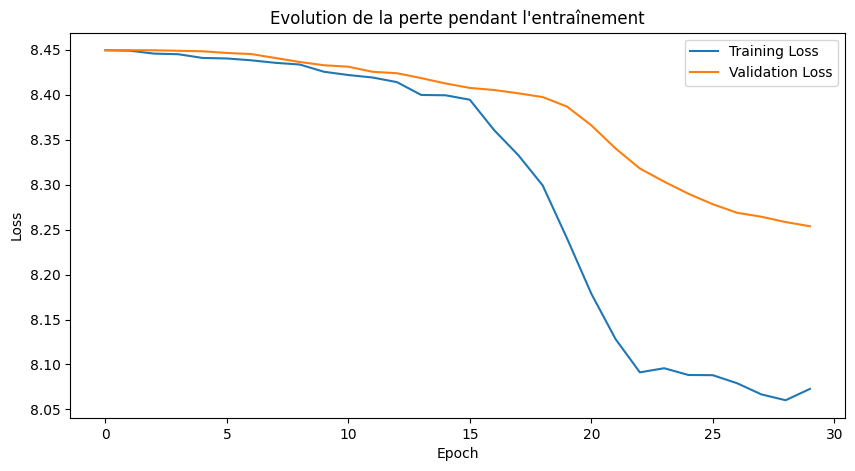

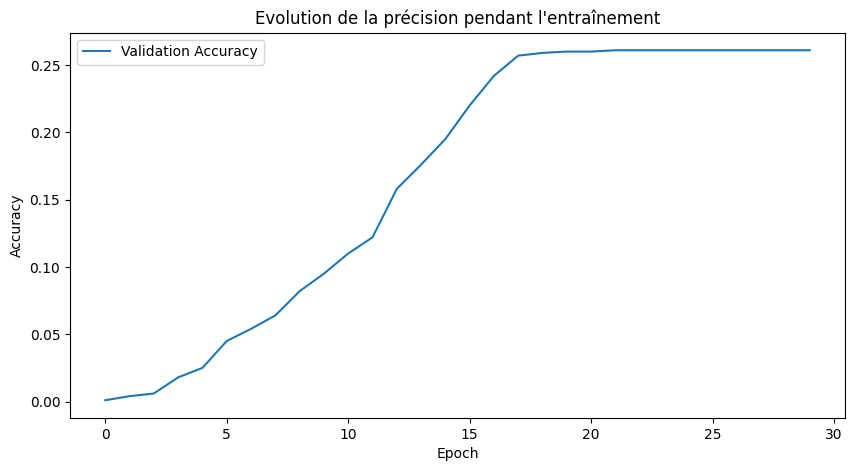

In [350]:
# Listes pour stocker les valeurs de perte et de précision
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Listes pour stocker les valeurs de perte et de précision
train_losses = []
val_losses = []
val_accuracies = []

# Entraînement et validation du modèle
num_epochs = 30
for epoch in range(num_epochs):
    total_train_correct = 0.0
    total_train_samples = 0.0
    train_loss = 0.0
    total_val_correct = 0.0
    total_val_samples = 0.0
    val_loss = 0.0
    # Entraînement
    model.train()  # Mettre le modèle en mode d'entraînement
    for inputs, labels in train_loader:
        labels=labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculer le nombre total de prédictions correctes
        _, predicted = th.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)
        
        # Collecter la perte pour l'époque
        train_loss += loss.item()
    
    # Calculer la précision et la perte moyenne d'entraînement
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation
    model.eval()  # Mettre le modèle en mode d'évaluation
    with th.no_grad():
        for inputs_val, labels_val in valid_loader:
            outputs_val = model(inputs_val)
            val_loss += criterion(outputs_val, labels_val.to(int)).item()
            
            # Calculer le nombre total de prédictions correctes
            _, predicted_val = th.max(outputs_val, 1)
            total_val_correct += (predicted_val == labels_val).sum().item()
            total_val_samples += labels_val.size(0)
    
    # Calculer la précision et la perte moyenne de validation
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = total_val_correct / total_val_samples
    
    # Ajouter les valeurs à nos listes
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Afficher les résultats de l'époque
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}')

# Tracer les courbes de perte et de précision
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution de la précision pendant l\'entraînement')
plt.legend()
plt.show()

# 4) Computing the FFT thanks to the compute_fft.py method : to continue

In [159]:
spectrogram=compute_spectrogram(xtrain,n_fft=1000)
spectrogram.shape

torch.Size([175995, 501, 13])

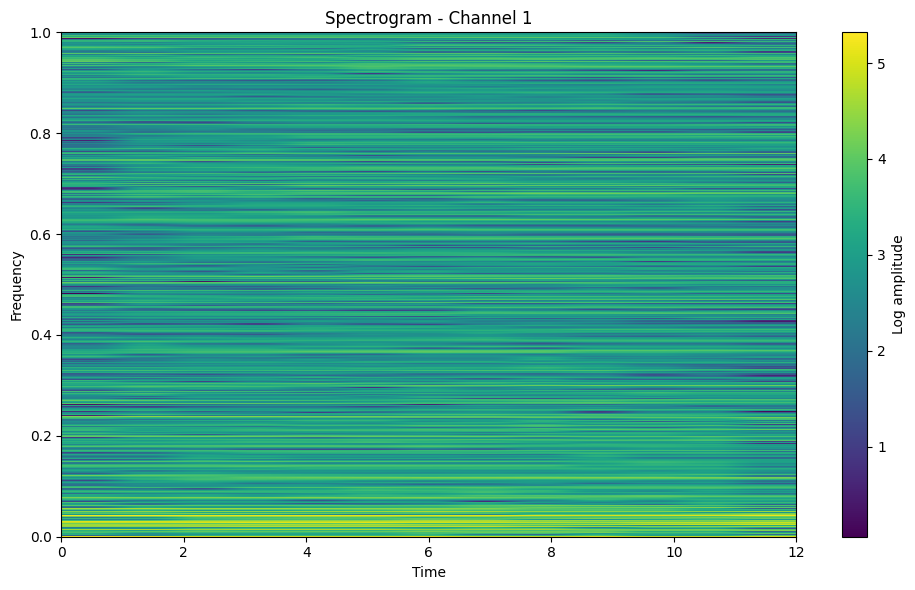

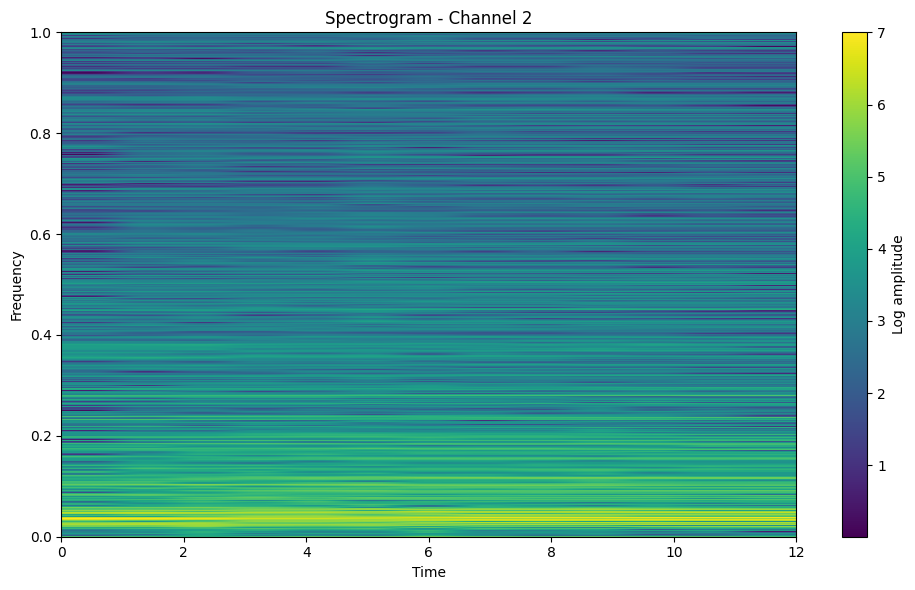

In [162]:
plot_spectrogram(spectrogram[0:2], sample_rate=1, title='Spectrogram', xlabel='Time', ylabel='Frequency')